# EDUFACE

-    this is a facial recognition system that will be integrated together with an LMS system to record student's attendance using facial recognition technology integrated.

### INSTALLING THE DEPENDENCIES.

In [2]:
!pip install tensorflow opencv-python matplotlib



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### IMPORTING THE DEPENDENCIES.

- we will install the standard dependencies first then install the tensor-flow dependencies later.

In [ ]:
#isntalling standard dependencies.

import cv2 #used to import open-cv into the noteboook
import os #OS system library that is needed when creating our Directories. it hence abstracts our operating system from our python
import random #used if we are generating new data.
import numpy as np #used when working with mathematical operations.
from matplotlib import pyplot as plt #


In [3]:
#we will now import tensorflow dependencies that will use tensorflow functional API components.
from tensorflow.keras.models import Model #this is one of most important layers since when creating a model we will need this when declaring Model(Inputs=>>> Output=>>) it enables us classify betwen output and input.
#our model will  look like: Model(inputs=[inputImage, verificationImage] output=[1,0]) this is what the model class helps us to do.
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten #model is a whole lot of abig class and we need these specific classes when building our model
#1. layer class is a high level class that helps you define a custom neural network layer
#2. conv2d - allows us to perform convolutions
#3. dense allows us to get a fully connected layer
#4. maxpooling2D allows us to pull our layers together and combine the information that we have through a condition
#5. Input allows us to identofy what we are passing through to our model.
#6. flatten takes the information from  a previous layer and flatten it into a single dimension
import tensorflow as tf

### Set GPU growth.
- here we are going to limit our amount of VRAM given to tensorflow hence you will keep on ending up to "out of memory error"

In [4]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("Number of GPUs available:", len(gpus))


Number of GPUs available: 0


### Setting up folder structure.
- we are going to set up the directories for

In [60]:
POS_Path=os.path.join('data', 'positive')
NEG_Path=os.path.join('data', 'negative')
ANC_Path=os.path.join('data', 'anchor')

#the above create the paths for the directories.

#os.path.join joins diferent directroy together to be able to get a full file path and you will be able to get  forward backslash or backward slash depeding on the Os that you are using



In [62]:
### Setting up folder structure.
# we are going to set up the directories for positive, negative, and anchor images

import os

# Define base path for consistency
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
DATA_PATH = os.path.join(BASE_PATH, 'data')

# CORRECTED: Use the data subdirectories consistently
POS_Path = os.path.join(DATA_PATH, 'positive')
NEG_Path = os.path.join(DATA_PATH, 'negative')
ANC_Path = os.path.join(DATA_PATH, 'anchor')

# Make the actual directories specified with the above paths
# exist_ok=True prevents errors if directories already exist
os.makedirs(POS_Path, exist_ok=True)
os.makedirs(NEG_Path, exist_ok=True)
os.makedirs(ANC_Path, exist_ok=True)

print(f"✅ Directories created/verified:")
print(f"   Positive: {POS_Path}")
print(f"   Negative: {NEG_Path}")
print(f"   Anchor: {ANC_Path}")

# Verify the paths are correct
print(f"\n🔍 Verifying paths exist:")
print(f"   Positive exists: {os.path.exists(POS_Path)}")
print(f"   Negative exists: {os.path.exists(NEG_Path)}")
print(f"   Anchor exists: {os.path.exists(ANC_Path)}")

✅ Directories created/verified:
   Positive: C:\Projects\EDUFACE PROJECT\data\positive
   Negative: C:\Projects\EDUFACE PROJECT\data\negative
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor

🔍 Verifying paths exist:
   Positive exists: True
   Negative exists: True
   Anchor exists: True


In [65]:
import tarfile
import os

# 1. Path to your LFW .tgz file
tgz_path = r"C:\Projects\EDUFACE PROJECT\lfw-funneled.tgz"

# 2. Extraction path - into the negative folder
extract_path = r"C:\Projects\EDUFACE PROJECT\data\negative"

# 3. Validate the .tgz file exists
if not os.path.isfile(tgz_path):
    raise FileNotFoundError(f"Error: The file '{tgz_path}' does not exist.")

print(f"Found .tgz file at: {tgz_path}")
print(f"File size: {os.path.getsize(tgz_path) / (1024*1024):.2f} MB")

# 4. Create extraction directory
os.makedirs(extract_path, exist_ok=True)

try:
    print(f"\n🔄 Extracting dataset to: {extract_path}")
    with tarfile.open(tgz_path, 'r:gz') as tar:
        # List first few members to see the structure
        members = tar.getmembers()
        print(f"Archive contains {len(members)} files/folders")
        print("First few items in archive:")
        for member in members[:5]:
            print(f"  - {member.name}")
        
        # Extract all
        tar.extractall(path=extract_path)
    print("✅ Dataset extracted successfully!")
    
except PermissionError:
    raise PermissionError(f"Permission denied. Try running as administrator.")
except tarfile.ReadError:
    raise ValueError(f"'{tgz_path}' is not a valid .tgz file.")
except Exception as e:
    raise Exception(f"Extraction failed: {str(e)}")

# 5. Find the actual root directory
print("\n🔍 Searching for dataset root...")
possible_roots = [
    os.path.join(extract_path, "lfw_funneled"),
    os.path.join(extract_path, "lfw-funneled"),
    os.path.join(extract_path, "lfw"),
]

lfw_root = None
for root in possible_roots:
    if os.path.exists(root) and os.path.isdir(root):
        lfw_root = root
        print(f"✅ Found dataset at: {lfw_root}")
        break

if lfw_root is None:
    # List what was actually extracted
    print(f"\n⚠️ Could not find expected folders. Contents of {extract_path}:")
    for item in os.listdir(extract_path):
        item_path = os.path.join(extract_path, item)
        item_type = "DIR" if os.path.isdir(item_path) else "FILE"
        print(f"  - [{item_type}] {item}")
    print("\nPlease check the extracted contents above.")
else:
    # 6. Analyze the dataset structure
    print("\n📊 Dataset Information:")
    person_folders = [d for d in os.listdir(lfw_root) if os.path.isdir(os.path.join(lfw_root, d))]
    print(f"Number of persons: {len(person_folders)}")
    print(f"First 10 persons: {person_folders[:10]}")
    
    # Count total images
    total_images = 0
    sample_person = None
    for person in person_folders[:10]:  # Check first 10 persons
        person_path = os.path.join(lfw_root, person)
        images = [f for f in os.listdir(person_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        total_images += len(images)
        if not sample_person and images:
            sample_person = (person, images[0])
    
    print(f"Sample: First 10 persons have {total_images} images")
    if sample_person:
        print(f"Example: {sample_person[0]}/{sample_person[1]}")
    print(f"\n✅ Dataset ready at: {lfw_root}")

Found .tgz file at: C:\Projects\EDUFACE PROJECT\lfw-funneled.tgz
File size: 232.07 MB

🔄 Extracting dataset to: C:\Projects\EDUFACE PROJECT\data\negative
Archive contains 18994 files/folders
First few items in archive:
  - lfw_funneled
  - lfw_funneled/George_HW_Bush
  - lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg
  - lfw_funneled/George_HW_Bush/George_HW_Bush_0002.jpg
  - lfw_funneled/George_HW_Bush/George_HW_Bush_0003.jpg
Archive contains 18994 files/folders
First few items in archive:
  - lfw_funneled
  - lfw_funneled/George_HW_Bush
  - lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg
  - lfw_funneled/George_HW_Bush/George_HW_Bush_0002.jpg
  - lfw_funneled/George_HW_Bush/George_HW_Bush_0003.jpg
✅ Dataset extracted successfully!

🔍 Searching for dataset root...
✅ Found dataset at: C:\Projects\EDUFACE PROJECT\data\negative\lfw_funneled

📊 Dataset Information:
✅ Dataset extracted successfully!

🔍 Searching for dataset root...
✅ Found dataset at: C:\Projects\EDUFACE PROJECT\d

### moving the lfw data into the data/negative data repository

In [66]:
### Setting up folder structure.
# we are going to set up the directories for positive, negative, and anchor images

import os

# Define base path for consistency
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
DATA_PATH = os.path.join(BASE_PATH, 'data')

# CORRECTED: Use the data subdirectories consistently
POS_Path = os.path.join(DATA_PATH, 'positive')
NEG_Path = os.path.join(DATA_PATH, 'negative')
ANC_Path = os.path.join(DATA_PATH, 'anchor')

# Make the actual directories specified with the above paths
# exist_ok=True prevents errors if directories already exist
os.makedirs(POS_Path, exist_ok=True)
os.makedirs(NEG_Path, exist_ok=True)
os.makedirs(ANC_Path, exist_ok=True)

print(f"✅ Directories created/verified:")
print(f"   Positive: {POS_Path}")
print(f"   Negative: {NEG_Path}")
print(f"   Anchor: {ANC_Path}")

# Verify the paths are correct
print(f"\n🔍 Verifying paths exist:")
print(f"   Positive exists: {os.path.exists(POS_Path)}")
print(f"   Negative exists: {os.path.exists(NEG_Path)}")
print(f"   Anchor exists: {os.path.exists(ANC_Path)}")

✅ Directories created/verified:
   Positive: C:\Projects\EDUFACE PROJECT\data\positive
   Negative: C:\Projects\EDUFACE PROJECT\data\negative
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor

🔍 Verifying paths exist:
   Positive exists: True
   Negative exists: True
   Anchor exists: True


## collect Positves and Anchors.
- we are going to use opencv and we are going to collect those images down nd save them down. the sime of the images to be collected are going to be 250 pixels by 250 pixels.

-   by default, when using webcam, the resolution of the images might be a little different so we should ensure that we are collecting images of that size because the sizes from the training dataset are of the same size.


In [86]:
## collect Positves and Anchors.
# we are going to use opencv and we are going to collect those images down and save them down. 
# the size of the images to be collected are going to be 250 pixels by 250 pixels.

import cv2
import numpy as np
import os
import time
import glob
import platform
import uuid

def find_working_webcam(max_index=10):
    """Try to find a working webcam by testing indices with optional backend."""
    backends = [None]  # Default backend
    if platform.system() == "Windows":
        backends.append(cv2.CAP_DSHOW)  # DirectShow
        backends.append(cv2.CAP_MSMF)   # Windows Media Foundation
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)   # V4L2

    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, frame = cap.read()
                print(f"Testing Index {index}, Backend {backend if backend else 'default'}: Opened={cap.isOpened()}, Frame captured={ret}")
                if ret:
                    print(f"✅ Webcam found at index {index} (backend: {backend if backend else 'default'})")
                    return cap, index
                cap.release()
    return None, None

# Fallback: Use a video file or static image for debugging if no webcam is found
fallback_source = os.path.join(BASE_PATH, "test_video.mp4")

# Ask for student details
student_name = input("Enter student name: ").strip().replace(" ", "_")
student_id = input("Enter school ID: ").strip()

# Validate student_id for safe file naming
invalid_chars = '<>:"/\\|?*'
for char in invalid_chars:
    student_id = student_id.replace(char, "_")

# Use the data/positive and data/anchor directories we created earlier
print(f"\n📁 Images will be saved to:")
print(f"   Anchor: {ANC_Path}")
print(f"   Positive: {POS_Path}")

# Initialize capture type
capture_type = "positive"  # Default capture type

# Function to get next count for a specific folder and type
def get_next_count(folder_path, student_name, student_id):
    """Get the next count number for files in the specified folder"""
    existing_files = glob.glob(os.path.join(folder_path, f"{student_name}_{student_id}_*.jpg"))
    if existing_files:
        counts = []
        for f in existing_files:
            try:
                basename = os.path.basename(f)
                # Extract number from filename
                parts = basename.replace(f"{student_name}_{student_id}_", "").replace(".jpg", "")
                # Extract the last number before UUID
                parts_split = parts.split('_')
                for part in parts_split:
                    if part.isdigit():
                        counts.append(int(part))
            except:
                continue
        return max(counts) + 1 if counts else 1
    else:
        return 1

# Initialize counters for each folder
anchor_count = get_next_count(ANC_Path, student_name, student_id)
positive_count = get_next_count(POS_Path, student_name, student_id)

# Load multiple Haar Cascades for different face orientations
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}

print("\nLoading face detection cascades...")
for cascade_name, cascade_file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + cascade_file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[cascade_name] = cascade
        print(f"✅ Loaded {cascade_name} cascade")
    else:
        print(f"⚠️ Could not load {cascade_name} cascade from {cascade_path}")

if not cascades:
    raise ValueError("Error: Could not load any Haar Cascade classifiers.")

def detect_faces_multi_angle(gray_frame):
    """Detect faces using multiple cascades for different angles"""
    all_faces = []
    detected_types = []
    
    for cascade_name, cascade in cascades.items():
        # Different parameters for different cascade types
        if 'profile' in cascade_name:
            faces = cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=4, minSize=(30, 30))
        else:
            faces = cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))
        
        for face in faces:
            all_faces.append(face)
            detected_types.append(cascade_name)
    
    return all_faces, detected_types

def remove_overlapping_faces(faces, detected_types, overlap_threshold=0.3):
    """Remove overlapping face detections to avoid duplicates"""
    if len(faces) <= 1:
        return faces, detected_types
    
    def calculate_overlap(box1, box2):
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        
        # Calculate intersection area
        x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
        y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
        intersection = x_overlap * y_overlap
        
        # Calculate union area
        area1 = w1 * h1
        area2 = w2 * h2
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0
    
    # Keep track of which faces to keep
    keep = [True] * len(faces)
    
    for i in range(len(faces)):
        if not keep[i]:
            continue
        for j in range(i + 1, len(faces)):
            if not keep[j]:
                continue
            
            overlap = calculate_overlap(faces[i], faces[j])
            if overlap > overlap_threshold:
                # Keep the larger face detection
                area1 = faces[i][2] * faces[i][3]
                area2 = faces[j][2] * faces[j][3]
                if area1 >= area2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    
    filtered_faces = [faces[i] for i in range(len(faces)) if keep[i]]
    filtered_types = [detected_types[i] for i in range(len(detected_types)) if keep[i]]
    
    return filtered_faces, filtered_types

# Initialize webcam
cap, webcam_index = find_working_webcam(max_index=10)
if cap is None:
    print("⚠️ No webcam found. Falling back to test source (video/image) for debugging.")
    if os.path.exists(fallback_source):
        cap = cv2.VideoCapture(fallback_source)
        webcam_index = "fallback"
        if not cap.isOpened():
            raise ValueError(f"Error: Could not open fallback source '{fallback_source}'.")
        print(f"Using fallback source: {fallback_source}")
    else:
        raise ValueError(f"Error: No webcam found, and fallback source '{fallback_source}' does not exist.")

print(f"\n👉 Using source: index {webcam_index if webcam_index != 'fallback' else fallback_source}")
print("👉 A video preview window will appear.")
print("👉 Press 'a' to switch to ANCHOR mode")
print("👉 Press 'p' to switch to POSITIVE mode")
print("👉 Press and hold 'c' to capture images continuously (every 0.2s).")
print("👉 The system will detect faces from multiple angles (front, profile, etc.)")
print("👉 Release 'c' to pause. Press and hold again to continue capturing.")
print("👉 Press 'q' to quit and save all captured images.")
print("⚠️ Images will be cropped to detected faces and saved with angle information.\n")
print("💡 TIP: Move your head to different angles while capturing for a better dataset!")
print("   - Look straight at camera (frontal)")
print("   - Turn left and right (profiles)")
print("   - Slightly tilt up and down\n")

# Flag to control capturing
is_capturing = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            if webcam_index == "fallback" and cap.get(cv2.CAP_PROP_POS_FRAMES) >= cap.get(cv2.CAP_PROP_FRAME_COUNT):
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Loop video
                continue
            print("Error: Failed to capture frame from source.")
            break

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detect faces from multiple angles
        faces, face_types = detect_faces_multi_angle(gray)
        
        # Remove overlapping detections
        faces, face_types = remove_overlapping_faces(faces, face_types)

        # Draw rectangles around detected faces with different colors for different types
        colors = {
            'frontal': (0, 255, 0),      # Green for frontal
            'profile': (255, 0, 0),      # Blue for profile
            'frontal_alt': (0, 255, 255), # Yellow for frontal alt
            'frontal_alt2': (255, 0, 255) # Magenta for frontal alt2
        }
        
        for i, (x, y, w, h) in enumerate(faces):
            face_type = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(face_type, (0, 255, 0))
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            
            # Add label showing the detection type
            label = face_type.replace('_', ' ').title()
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Add status text
        status_text = f"Mode: {capture_type.upper()} | Faces: {len(faces)} | {'CAPTURING' if is_capturing else 'PAUSED'}"
        cv2.putText(frame, status_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(frame, status_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 1)
        
        # Add counts
        count_text = f"Anchor: {anchor_count-1} | Positive: {positive_count-1}"
        cv2.putText(frame, count_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, count_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

        # Display the frame
        cv2.imshow("Multi-Angle Face Capture - 'a' anchor, 'p' positive, 'c' capture, 'q' quit", frame)

        # Check for keypress
        key = cv2.waitKey(1) & 0xFF

        # Handle mode switching
        if key == ord('a'):
            capture_type = 'anchor'
            print(f"🔄 Switched to ANCHOR capture mode")
        elif key == ord('p'):
            capture_type = "positive"
            print(f"🔄 Switched to POSITIVE capture mode")
        elif key == ord('c'):
            is_capturing = True
        elif key == 255:  # No key pressed (equivalent to releasing 'c')
            is_capturing = False
        elif key == ord('q'):
            print("\n👋 Exiting capture...")
            break

        # Capture and save faces if 'c' is held
        if is_capturing and faces:
            # Pick folder and counter based on current capture type
            if capture_type == "anchor":
                save_folder = ANC_Path
                current_count = anchor_count
            else:
                save_folder = POS_Path
                current_count = positive_count
            
            for i, (x, y, w, h) in enumerate(faces):
                face_crop = frame[y:y+h, x:x+w]
                
                # Determine angle/type for filename
                face_type = face_types[i] if i < len(face_types) else 'frontal'
                angle_name = face_type.replace('frontal', 'front').replace('_alt', '').replace('_alt2', '')
                
                # Create filename with UUID for uniqueness
                unique_id = str(uuid.uuid4())[:8]  # Use first 8 characters of UUID
                filename = os.path.join(save_folder, f"{student_name}_{student_id}_{angle_name}_{current_count}_{unique_id}.jpg")
                
                # Resize face crop to standard size (250x250 as specified)
                face_resized = cv2.resize(face_crop, (250, 250))
                
                cv2.imwrite(filename, face_resized)
                print(f"✅ Saved {filename} (Type: {face_type}, Mode: {capture_type})")
                
                # Increment the appropriate counter
                if capture_type == "anchor":
                    anchor_count += 1
                else:
                    positive_count += 1
            
            time.sleep(0.2)  # Capture every 0.2 seconds to avoid oversaving

finally:
    # Cleanup
    cap.release()
    cv2.destroyAllWindows()

# Final statistics
total_anchor = len(glob.glob(os.path.join(ANC_Path, "*.jpg")))
total_positive = len(glob.glob(os.path.join(POS_Path, "*.jpg")))

print(f"\n👋 Capture session complete!")
print(f"📁 Images saved in:")
print(f"   📁 Anchor folder: {ANC_Path} ({total_anchor} images)")
print(f"   📁 Positive folder: {POS_Path} ({total_positive} images)")

print("\n📊 Dataset Summary:")
# Count different types of images in each folder
for folder_name, folder_path in [("Anchor", ANC_Path), ("Positive", POS_Path)]:
    angle_counts = {}
    for f in glob.glob(os.path.join(folder_path, "*.jpg")):
        basename = os.path.basename(f)
        if 'front' in basename:
            angle_counts['frontal'] = angle_counts.get('frontal', 0) + 1
        elif 'profile' in basename:
            angle_counts['profile'] = angle_counts.get('profile', 0) + 1
        else:
            angle_counts['other'] = angle_counts.get('other', 0) + 1
    
    print(f"   {folder_name}:")
    for angle, count in angle_counts.items():
        print(f"     - {angle.title()}: {count} images")


📁 Images will be saved to:
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor
   Positive: C:\Projects\EDUFACE PROJECT\data\positive

Loading face detection cascades...
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade
Testing Index 0, Backend default: Opened=True, Frame captured=True
✅ Webcam found at index 0 (backend: default)

👉 Using source: index 0
👉 A video preview window will appear.
👉 Press 'a' to switch to ANCHOR mode
👉 Press 'p' to switch to POSITIVE mode
👉 Press and hold 'c' to capture images continuously (every 0.2s).
👉 The system will detect faces from multiple angles (front, profile, etc.)
👉 Release 'c' to pause. Press and hold again to continue capturing.
👉 Press 'q' to quit and save all captured images.
⚠️ Images will be cropped to detected faces and saved with angle information.

💡 TIP: Move your head to different angles while capturing for a better dataset!
   - Look straight at camera (frontal)
   - Turn lef

### Load and Preprocess images

#### Get image Directories

In [89]:
### Load and Preprocess images - Get image Directories
import tensorflow as tf
import glob

print("\n📂 Loading image datasets...")

# Get all image paths
anchor_images = glob.glob(os.path.join(ANC_Path, '*.jpg'))
positive_images = glob.glob(os.path.join(POS_Path, '*.jpg'))

# For negative images, they're now in subdirectories after extraction
# Get all images recursively from the negative folder
negative_images = glob.glob(os.path.join(NEG_Path, '**', '*.jpg'), recursive=True)

print(f"✅ Found images:")
print(f"   Anchor: {len(anchor_images)} images")
print(f"   Positive: {len(positive_images)} images")
print(f"   Negative: {len(negative_images)} images")

# Create TensorFlow datasets from the file paths
anchor = tf.data.Dataset.from_tensor_slices(anchor_images)
positive = tf.data.Dataset.from_tensor_slices(positive_images)
negative = tf.data.Dataset.from_tensor_slices(negative_images)

print("\n✅ TensorFlow datasets created successfully!")


📂 Loading image datasets...
✅ Found images:
   Anchor: 437 images
   Positive: 398 images
   Negative: 13233 images

✅ TensorFlow datasets created successfully!
✅ Found images:
   Anchor: 437 images
   Positive: 398 images
   Negative: 13233 images

✅ TensorFlow datasets created successfully!


### Preprocessing

- we are going to write a function that loads an image from the directory, resize it and perform scaling on it. 
- we are going to convert all of our image values from 0-255 to 0-1. And this helps our neural network optimize easier and better as it makes the gradient descent a little bit easier hence a better performing model.

In [90]:
### Preprocessing Function
### Preprocessing Function
def preprocess(file_path):
    """Load, decode, resize and scale an image"""
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0  # Scale to 0-1
    return img
#what this function does is that it takes in the filepath of an image and returns the numpy equivalent of the image after resizing and scaling it.
#we also come to learn that the min value of the numpy is 0 and the max value is 1.0

#in short we take an image from a directory as we did in the tf.data.Dataset.list_files method and we read it, decode it, resize it and scale it to be between 0 and 1.0 as it helps to reduce the gradient descent and reduce our computation of our model. 

In [95]:
# 1. Define preprocessing functions
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

# 2. Get dataset lengths and trim
anchor_len = tf.data.experimental.cardinality(anchor).numpy()
positive_len = tf.data.experimental.cardinality(positive).numpy()
negative_len = tf.data.experimental.cardinality(negative).numpy()

min_len = min(anchor_len, positive_len, negative_len)
print(f"\n📊 Dataset balancing:")
print(f"   Anchor: {anchor_len} → {min_len}")
print(f"   Positive: {positive_len} → {min_len}")
print(f"   Negative: {negative_len} → {min_len}")

# 3. Trim datasets
anchor_trimmed = anchor.take(min_len)
positive_trimmed = positive.take(min_len)
negative_trimmed = negative.take(min_len)

# 4. Create pairs
positives = tf.data.Dataset.zip((
    anchor_trimmed, 
    positive_trimmed, 
    tf.data.Dataset.from_tensor_slices(tf.ones(min_len))
))

negatives = tf.data.Dataset.zip((
    anchor_trimmed, 
    negative_trimmed, 
    tf.data.Dataset.from_tensor_slices(tf.zeros(min_len))
))

# 5. Combine and build pipeline
data = positives.concatenate(negatives)
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)
data = data.batch(16)
data = data.prefetch(8)

print(f"\n✅ Data pipeline complete!")
print(f"   Total samples: {min_len * 2} (positive + negative)")
print(f"   Batch size: 16")
print(f"   Total batches: {tf.data.experimental.cardinality(data).numpy()}")


📊 Dataset balancing:
   Anchor: 437 → 398
   Positive: 398 → 398
   Negative: 13233 → 398

✅ Data pipeline complete!
   Total samples: 796 (positive + negative)
   Batch size: 16
   Total batches: 50


In [ ]:
# sample=data.as_numpy_iterator()
# example = sample.next()
# print(example)

(array([[[[0.00000000e+00, 2.45098054e-04, 9.28921580e-01],
         [1.76470596e-02, 0.00000000e+00, 8.65686297e-01],
         [2.15686280e-02, 1.98529419e-02, 8.66666675e-01],
         ...,
         [0.00000000e+00, 2.94117653e-03, 8.38970602e-01],
         [6.61764713e-03, 0.00000000e+00, 8.47058833e-01],
         [0.00000000e+00, 9.80392192e-03, 9.36274529e-01]],

        [[1.54411765e-02, 1.47058826e-03, 8.68137240e-01],
         [7.30392158e-01, 7.08088219e-01, 9.70343113e-01],
         [7.47303903e-01, 7.43872523e-01, 8.90686274e-01],
         ...,
         [7.75735319e-01, 7.65686274e-01, 9.41176474e-01],
         [7.79411793e-01, 7.65686274e-01, 9.25735295e-01],
         [4.02941167e-01, 4.01470602e-01, 9.34068620e-01]],

        [[1.25000002e-02, 5.88235306e-03, 8.55882347e-01],
         [7.66911745e-01, 7.52205908e-01, 9.01960790e-01],
         [8.04166675e-01, 7.88725495e-01, 7.90441155e-01],
         ...,
         [8.34803939e-01, 8.13970566e-01, 8.37254882e-01],
         

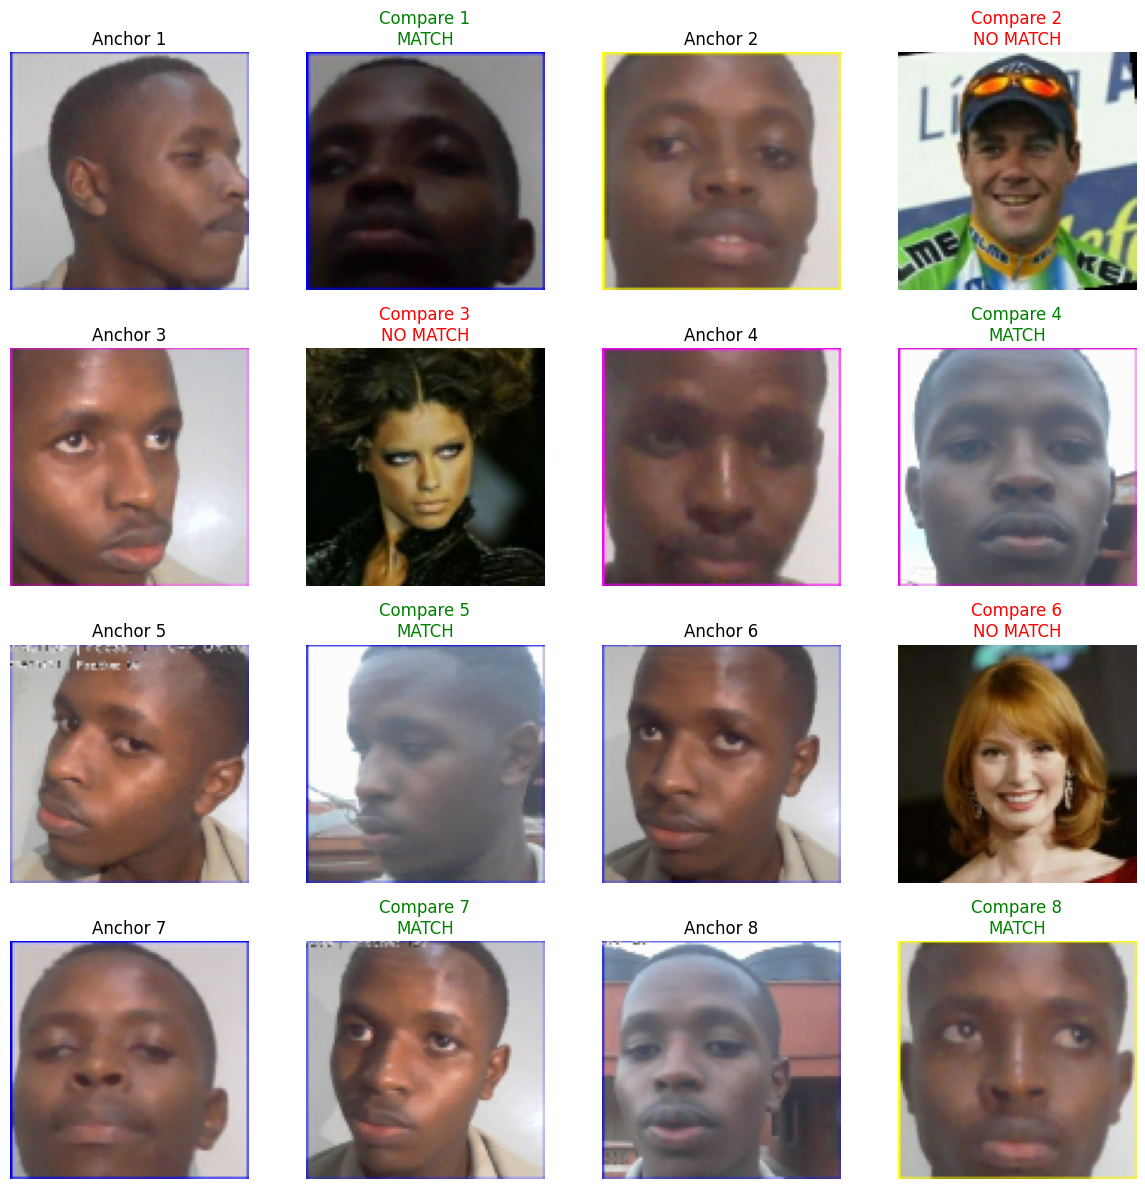


📊 Batch Statistics:
   Positive pairs (label=1): 9
   Negative pairs (label=0): 7


In [97]:
from matplotlib import pyplot as plt

# Get a batch
samples = data.as_numpy_iterator()
batch = samples.next()
anchor, comparison, labels = batch

# Visualize first 8 pairs
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(8):
    # Anchor image
    axes[i//2, (i%2)*2].imshow(anchor[i])
    axes[i//2, (i%2)*2].set_title(f"Anchor {i+1}")
    axes[i//2, (i%2)*2].axis('off')
    
    # Comparison image
    axes[i//2, (i%2)*2 + 1].imshow(comparison[i])
    label_text = "MATCH" if labels[i] == 1.0 else "NO MATCH"
    color = 'green' if labels[i] == 1.0 else 'red'
    axes[i//2, (i%2)*2 + 1].set_title(f"Compare {i+1}\n{label_text}", color=color)
    axes[i//2, (i%2)*2 + 1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n📊 Batch Statistics:")
print(f"   Positive pairs (label=1): {int(labels.sum())}")
print(f"   Negative pairs (label=0): {int(len(labels) - labels.sum())}")

In [99]:
### Split into Train, Validation, and Test sets

# Calculate total number of batches
total_batches = tf.data.experimental.cardinality(data).numpy()
print(f"\n📊 Total batches in dataset: {total_batches}")

# Calculate split sizes (70% train, 15% validation, 15% test)
train_size = int(total_batches * 0.70)
val_size = int(total_batches * 0.15)
test_size = total_batches - train_size - val_size  # Remaining goes to test

print(f"\n✂️ Splitting dataset:")
print(f"   Training: {train_size} batches (70%)")
print(f"   Validation: {val_size} batches (15%)")
print(f"   Test: {test_size} batches (15%)")

# Create the splits
train_data = data.take(train_size)
remaining = data.skip(train_size)
val_data = remaining.take(val_size)
test_data = remaining.skip(val_size)

print(f"\n✅ Data partitions created!")
print(f"   🏋️ Training batches: {tf.data.experimental.cardinality(train_data).numpy()}")
print(f"   🎯 Validation batches: {tf.data.experimental.cardinality(val_data).numpy()}")
print(f"   🧪 Test batches: {tf.data.experimental.cardinality(test_data).numpy()}")


📊 Total batches in dataset: 50

✂️ Splitting dataset:
   Training: 35 batches (70%)
   Validation: 7 batches (15%)
   Test: 8 batches (15%)

✅ Data partitions created!
   🏋️ Training batches: 35
   🎯 Validation batches: 7
   🧪 Test batches: 8


In [103]:
# You already have these values
batch_size = 16  # This was set earlier when you did data.batch(16)
train_batches = train_size  # 35
val_batches = val_size      # 7
test_batches = test_size    # 8

# Calculate total samples
train_samples = train_batches * batch_size
val_samples = val_batches * batch_size
test_samples = test_batches * batch_size

print(f"\n📊 Total samples (images pairs):")
print(f"   🏋️ Training: {train_samples} samples ({train_batches} batches × {batch_size})")
print(f"   🎯 Validation: {val_samples} samples ({val_batches} batches × {batch_size})")
print(f"   🧪 Test: {test_samples} samples ({test_batches} batches × {batch_size})")
print(f"   📦 TOTAL: {train_samples + val_samples + test_samples} samples")



📊 Total samples (images pairs):
   🏋️ Training: 560 samples (35 batches × 16)
   🎯 Validation: 112 samples (7 batches × 16)
   🧪 Test: 128 samples (8 batches × 16)
   📦 TOTAL: 800 samples
